In [2]:
import sys
import os
import pandas as pd
from IPython.display import display

# Add src to path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))

from data_loader import load_fraud_data

# Load data
fraud_df = load_fraud_data("../data/Fraud_Data.csv")
print("✅ Fraud data loaded.")


✅ Fraud data loaded.


In [3]:
# Check total missing values
print("🔍 Total missing values in Fraud_Data:")
total_missing = fraud_df.isnull().sum()
display(total_missing[total_missing > 0])

# Summary
if total_missing.sum() == 0:
    print("✅ No missing values found.")
else:
    print("⚠️ Missing values found. Next step: drop or impute.")


🔍 Total missing values in Fraud_Data:


Series([], dtype: int64)

✅ No missing values found.


In [4]:
# Drop rows with missing values
fraud_df_clean = fraud_df.dropna()

print(f"✅ Dropped {fraud_df.shape[0] - fraud_df_clean.shape[0]} rows with missing values.")


✅ Dropped 0 rows with missing values.


In [5]:
 #Save cleaned version for later use
fraud_df_clean.to_csv("../data/fraud_data_clean.csv", index=False)


2,Data Cleaning

remove Duplicates

In [6]:
# Check and remove duplicates
duplicate_count = fraud_df_clean.duplicated().sum()
print(f"🧹 Found {duplicate_count} duplicate rows.")

fraud_df_clean = fraud_df_clean.drop_duplicates()
print(f"✅ Duplicate rows removed. Current shape: {fraud_df_clean.shape}")


🧹 Found 0 duplicate rows.
✅ Duplicate rows removed. Current shape: (151112, 11)


Inspect Data Types

In [7]:
# Show data types before any conversion
print("🔍 Data types before conversion:")
display(fraud_df_clean.dtypes)


🔍 Data types before conversion:


user_id             int64
signup_time        object
purchase_time      object
purchase_value      int64
device_id          object
source             object
browser            object
sex                object
age                 int64
ip_address        float64
class               int64
dtype: object

Convert Timestamp Columns (early type correction)

In [8]:
# Convert signup_time and purchase_time to datetime
fraud_df_clean['signup_time'] = pd.to_datetime(fraud_df_clean['signup_time'], errors='coerce')
fraud_df_clean['purchase_time'] = pd.to_datetime(fraud_df_clean['purchase_time'], errors='coerce')

# Confirm changes
print("✅ Converted 'signup_time' and 'purchase_time' to datetime.")
display(fraud_df_clean[['signup_time', 'purchase_time']].head())


✅ Converted 'signup_time' and 'purchase_time' to datetime.


,signup_time,purchase_time
0,2015-02-24 22:55:49,2015-04-18 02:47:11
1,2015-06-07 20:39:50,2015-06-08 01:38:54
2,2015-01-01 18:52:44,2015-01-01 18:52:45
3,2015-04-28 21:13:25,2015-05-04 13:54:50
4,2015-07-21 07:09:52,2015-09-09 18:40:53


Re-check for new missing values

In [9]:
# Re-check for NaT values after datetime conversion
print("🔍 Missing datetime values after conversion:")
display(fraud_df_clean[['signup_time', 'purchase_time']].isnull().sum())

# Drop rows if any timestamps failed to convert
fraud_df_clean = fraud_df_clean.dropna(subset=['signup_time', 'purchase_time'])
print("✅ Dropped rows with invalid timestamps (if any).")


🔍 Missing datetime values after conversion:


signup_time      0
purchase_time    0
dtype: int64

✅ Dropped rows with invalid timestamps (if any).


3,Exploratory Data Analysis (EDA)

Class Distribution (Univariate)

C:\Users\filimon.hailemariam\AppData\Local\Temp\ipykernel_21636\1562301822.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='class', data=fraud_df_clean, palette='Set2')


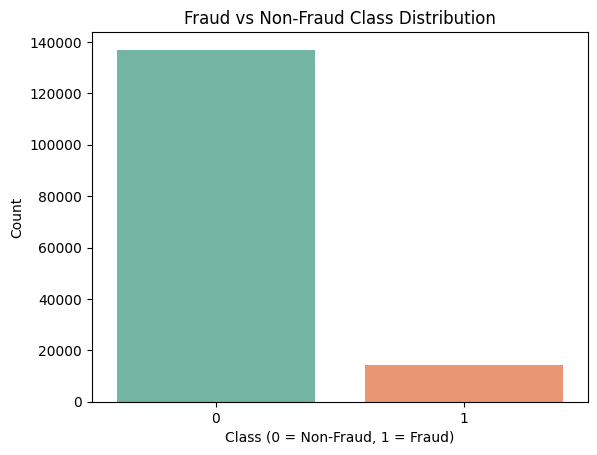


⚖️ Class Distribution (normalized):
class
0    0.906354
1    0.093646
Name: proportion, dtype: float64


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='class', data=fraud_df_clean, palette='Set2')
plt.title("Fraud vs Non-Fraud Class Distribution")
plt.xlabel("Class (0 = Non-Fraud, 1 = Fraud)")
plt.ylabel("Count")
plt.show()

# Print class balance %
fraud_ratio = fraud_df_clean['class'].value_counts(normalize=True)
print(f"\n⚖️ Class Distribution (normalized):\n{fraud_ratio}")


Purchase Value by Class (Boxplot)

C:\Users\filimon.hailemariam\AppData\Local\Temp\ipykernel_21636\1322287570.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=fraud_df_clean, x='class', y='purchase_value', palette='Set3')


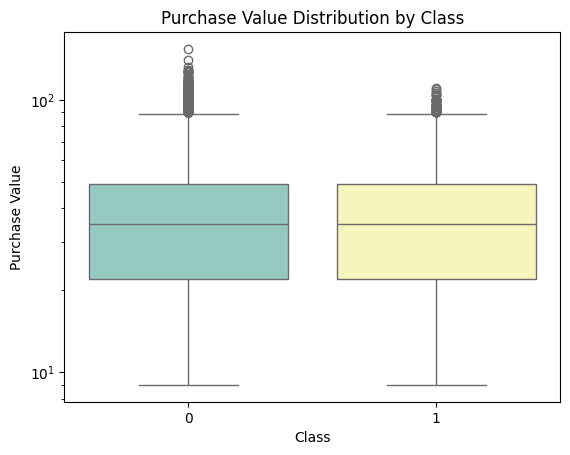

In [11]:
sns.boxplot(data=fraud_df_clean, x='class', y='purchase_value', palette='Set3')
plt.title("Purchase Value Distribution by Class")
plt.xlabel("Class")
plt.ylabel("Purchase Value")
plt.yscale('log')  # Handle skew
plt.show()


Interpretation: Purchase Value Distribution by Class
This boxplot compares purchase values for non-fraud (Class 0) vs fraud (Class 1) transactions:

Both classes have similar medians and spread, indicating no strong difference in purchase value.

Outliers are present in both classes, with frauds showing slightly lower upper whiskers, suggesting slightly less extreme high-value transactions.

🔍 Insight:
Purchase value alone does not strongly distinguish fraud from non-fraud. It may be more useful when combined with other behavioral patterns.

Age Distribution (Univariate + by Class)

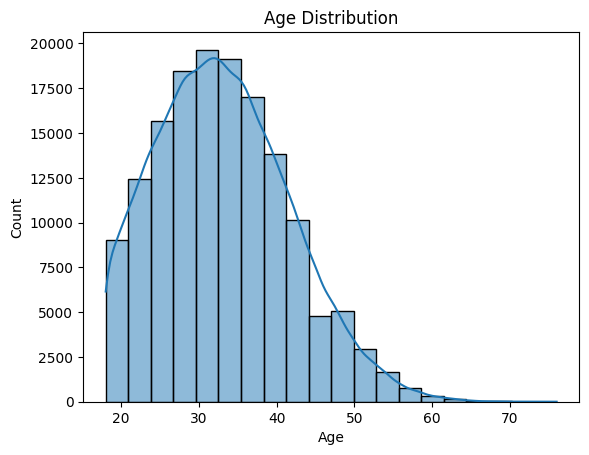

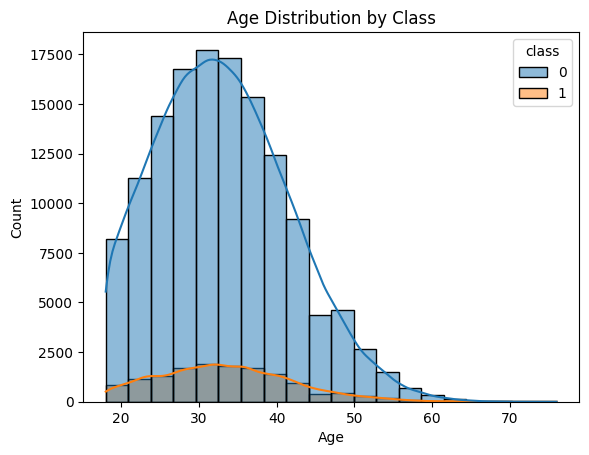

In [12]:
sns.histplot(data=fraud_df_clean, x='age', bins=20, kde=True)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

sns.histplot(data=fraud_df_clean, x='age', hue='class', bins=20, kde=True)
plt.title("Age Distribution by Class")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()


Interpretation: Age Distribution by Class
This histogram shows age distributions for both fraud (Class 1) and non-fraud (Class 0) users:

Most transactions are made by users aged 25–40, with both classes peaking around age 30.

The fraudulent transactions (orange line) are more evenly spread across ages and slightly flatter, indicating fraud is not strongly age-dependent.

Non-fraud (blue) has a stronger peak, suggesting legitimate users cluster more tightly around a specific age group.

🔍 Insight:
Age shows some variance but is not a strong discriminator between fraud and non-fraud—useful when combined with behavioral or transactional patterns.

Fraud by Source, Browser, and Sex (Bivariate)

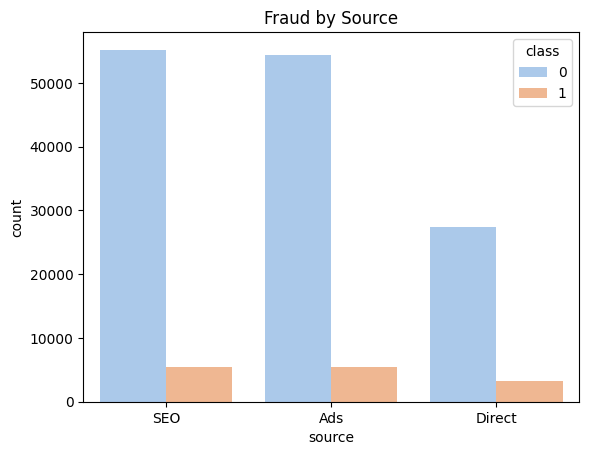

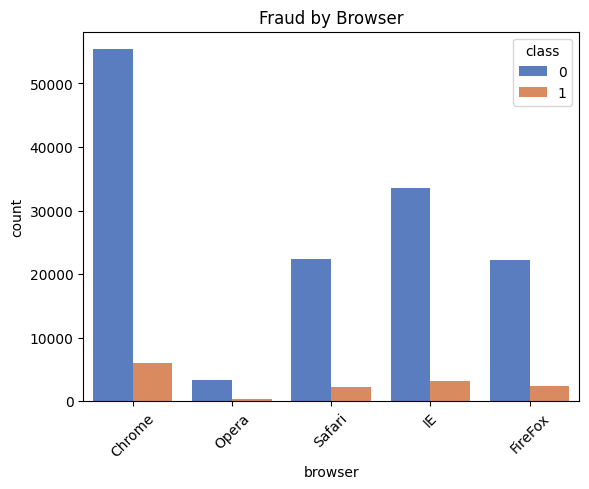

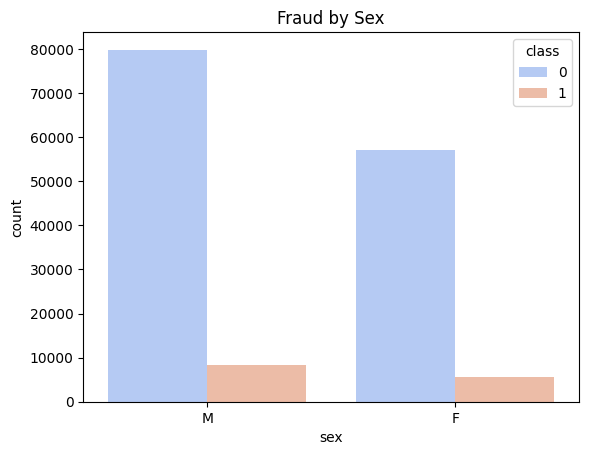

In [13]:
# Source vs Class
sns.countplot(data=fraud_df_clean, x='source', hue='class', palette='pastel')
plt.title("Fraud by Source")
plt.show()

# Browser vs Class
sns.countplot(data=fraud_df_clean, x='browser', hue='class', palette='muted')
plt.title("Fraud by Browser")
plt.xticks(rotation=45)
plt.show()

# Sex vs Class
sns.countplot(data=fraud_df_clean, x='sex', hue='class', palette='coolwarm')
plt.title("Fraud by Sex")
plt.show()


Fraud Distribution Insights
📌 Fraud by Source
SEO and Ads are the most common traffic sources.

Fraudulent transactions are distributed across all sources, but Direct traffic shows a relatively higher fraud ratio compared to its volume.

🌐 Fraud by Browser
Chrome dominates overall traffic and fraud volume.

IE (Internet Explorer) and Safari also show notable fraud cases.

Opera has the least usage and lowest fraud, suggesting it may be less targeted.

👥 Fraud by Sex
Male users (M) conduct more transactions overall.

However, fraudulent transactions are slightly more concentrated in males, potentially indicating a behavioral or demographic risk factor.



C:\Users\filimon.hailemariam\AppData\Local\Temp\ipykernel_21636\721927552.py:14: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\filimon.hailemariam\Downloads\Week 8&9\fraud-detection-ecommerce-banking\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


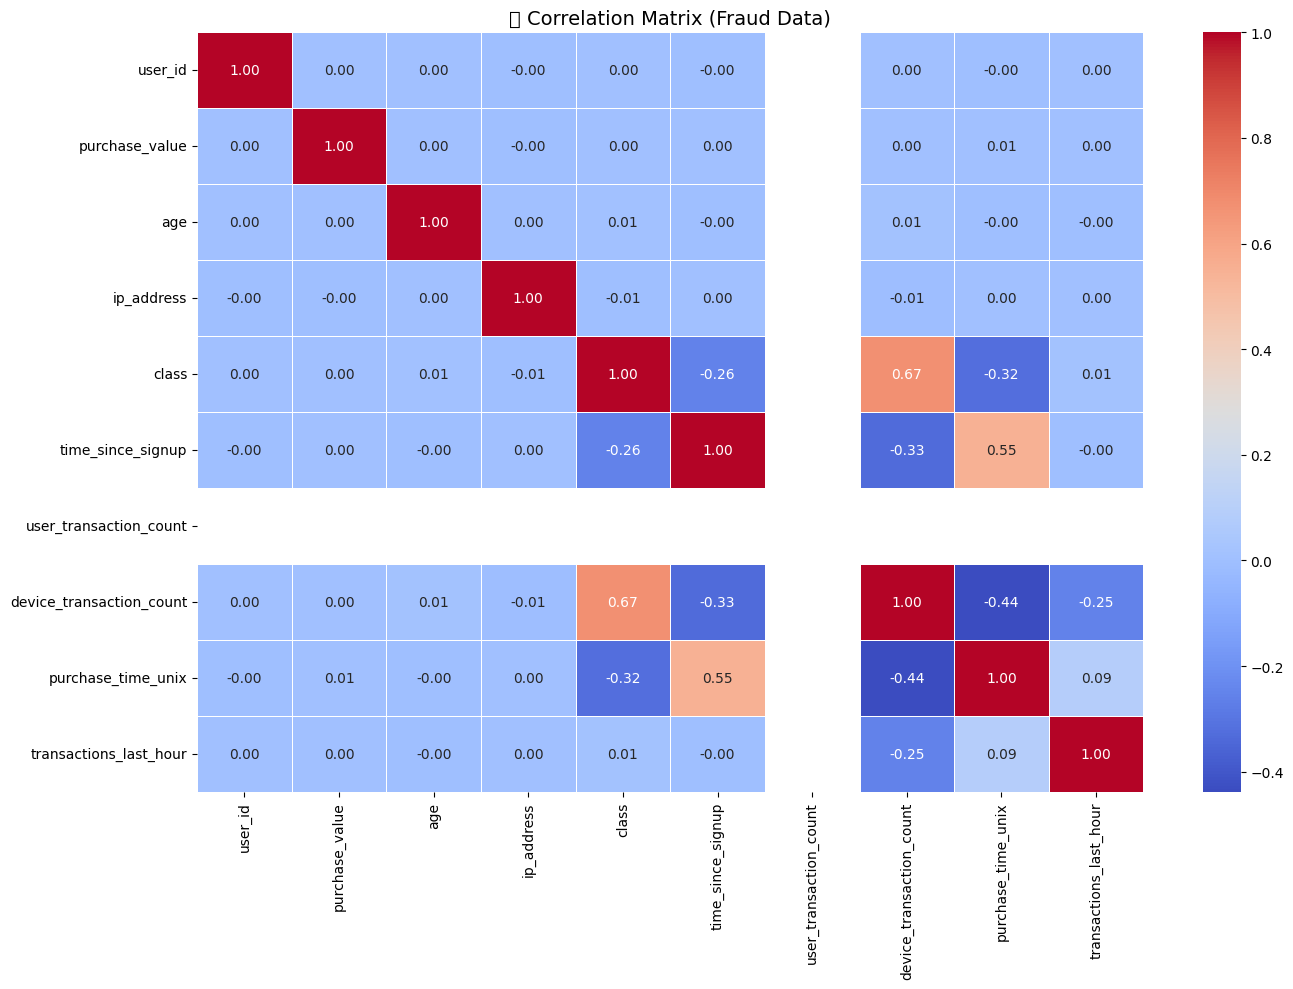

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Only numeric columns
numeric_cols = fraud_df_clean.select_dtypes(include=['int64', 'float64']).columns

# Compute correlation
correlation_matrix = fraud_df_clean[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("🔗 Correlation Matrix (Fraud Data)", fontsize=14)
plt.tight_layout()
plt.show()


This correlation matrix for the fraud dataset reveals several key insights:
•	Most variables show very weak correlation with the target class, except for time_since_signup, which has a moderate negative correlation (-0.26) with fraud—implying newer users are more likely to commit fraud.
•	device_transaction_count and user_transaction_count are strongly positively correlated (0.67), suggesting frequent user activity is often tied to specific devices.
•	purchase_time_unix and time_since_signup also show moderate positive correlation (0.55), likely due to temporal dependencies.
Conclusion: Engineered features like time_since_signup and transaction counts enhance the signal for fraud detection better than raw features like purchase_value or age, which show minimal influence.


Duplicates & Unique Analysis

In [14]:
print("🔍 Unique values:")
print("Users:", fraud_df_clean['user_id'].nunique())
print("Devices:", fraud_df_clean['device_id'].nunique())
print("IP Addresses:", fraud_df_clean['ip_address'].nunique())


🔍 Unique values:
Users: 151112
Devices: 137956
IP Addresses: 143512
